## Project Title :SyriaTel Customer Churn Prediction

### Business Understanding
Stakeholder: Customer Retention Department of SyriaTel.

Business Problem: SyriaTel is experiencing customer loss (churn) to competitors. High churn rates directly impact revenue and market share. Because retaining an existing customer is more cost-effective than acquiring a new one, SyriaTel needs a predictive model to identify customers likely to leave.

Objective: Develop a classification model that identifies at-risk customers with high Recall to minimize missed opportunities for retention.

### Data Understanding
The dataset consists of 3,333 records with 21 features.

Target: churn (Boolean: True/False).

Key Features: Account length, usage minutes (day, evening, night, international), service plans, and customer service calls.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

# Load dataset
data = pd.read_csv ('bigml_59c28831336c6604c800002a.csv')

# Initial inspection
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

### Data Preparation
We performed feature selection to remove identifiers (phone numbers) and geographic data. We also addressed multicollinearity by removing "Charge" variables, which are perfectly correlated with "Minutes."

In [2]:
# Drop non-predictive and redundant features
data_clean = data.drop(columns=['phone number', 'state', 'area code', 
                                'total day charge', 'total eve charge', 
                                'total night charge', 'total intl charge'])

# Encode categorical variables
le = LabelEncoder()
data_clean['international plan'] = le.fit_transform(data_clean['international plan'])
data_clean['voice mail plan'] = le.fit_transform(data_clean['voice mail plan'])
data_clean['churn'] = data_clean['churn'].astype(int)

# Split data (80/20 split)
X = data_clean.drop('churn', axis=1)
y = data_clean['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling
We utilize Logistic Regression as our baseline model. This choice provides high interpretability, allowing us to see which specific behaviors drive a customer to leave.

In [3]:
# Initialize and train the model
logreg = LogisticRegression(class_weight='balanced') # Balanced weights address the 14.5% churn minority
logreg.fit(X_train_scaled, y_train)

# Generate predictions
y_pred = logreg.predict(X_test_scaled)
print()

In [4]:
#Linear Regression
#Fits a linear relationship between features and churn.
#Predicts churn values on test data.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression RMSE:",mean_squared_error(y_test, y_pred_lr, squared=False))
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))

#RMSE: Average prediction error (lower is better).

#R²: Proportion of variance explained by the model (closer to 1 is better).

#Serves as a baseline model.

Linear Regression RMSE: 0.3225362721346072
Linear Regression R2: 0.16292918151368663


In [5]:
#Ridge Regression
#Adds an L2 penalty to the loss function.
#Shrinks large coefficients.

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge RMSE:", mean_squared_error(y_test, y_pred_ridge, squared=False))
print("Ridge R2:", r2_score(y_test, y_pred_ridge))
print("Coefficient:",ridge.coef_)
#Reduces overfitting.

#Handles multicollinearity better than linear regression.


Ridge RMSE: 0.32252852822270844
Ridge R2: 0.16296937621682195
Coefficient: [ 0.00508084  0.08687154 -0.06850508  0.03421978  0.06510309  0.00749768
  0.0347489   0.0043154   0.01104409  0.00086511  0.02191523 -0.02158591
  0.08490188]


### Evaluation
We evaluate the model using a Confusion Matrix and Classification Report. Our primary metric is Recall, as SyriaTel's priority is to "capture" as many churners as possible.

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84       570
           1       0.35      0.74      0.47        97

    accuracy                           0.76       667
   macro avg       0.65      0.75      0.66       667
weighted avg       0.86      0.76      0.79       667



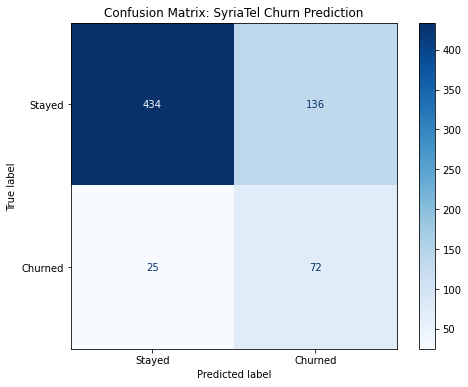

                   Feature  Coefficient
12  customer service calls     0.816153
1       international plan     0.694133
4        total day minutes     0.666116
3    number vmail messages     0.586763
6        total eve minutes     0.346550
10      total intl minutes     0.195773
8      total night minutes     0.116730
7          total eve calls     0.076826
0           account length     0.074497
5          total day calls     0.051665
9        total night calls     0.001661
11        total intl calls    -0.174115
2          voice mail plan    -0.935412


In [6]:
# Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(logreg, X_test_scaled, y_test, display_labels=['Stayed', 'Churned'], cmap='Blues', ax=ax)
plt.title('Confusion Matrix: SyriaTel Churn Prediction')
plt.show()

# Identifying Key Drivers (Feature Importance)
importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
importance = importance.sort_values(by='Coefficient', ascending=False)
print(importance)

### Decision Tree Clasiffier


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

#use for loop to encode our categorical to numeric
for col in data.columns:
  data[col] = encoder.fit_transform(data[col])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   state                   3333 non-null   int32
 1   account length          3333 non-null   int64
 2   area code               3333 non-null   int64
 3   phone number            3333 non-null   int32
 4   international plan      3333 non-null   int32
 5   voice mail plan         3333 non-null   int32
 6   number vmail messages   3333 non-null   int64
 7   total day minutes       3333 non-null   int64
 8   total day calls         3333 non-null   int64
 9   total day charge        3333 non-null   int64
 10  total eve minutes       3333 non-null   int64
 11  total eve calls         3333 non-null   int64
 12  total eve charge        3333 non-null   int64
 13  total night minutes     3333 non-null   int64
 14  total night calls       3333 non-null   int64
 15  total night charge   

In [8]:
X = data.drop(['churn'], axis=1)
y = data['churn']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=254, test_size=0.7)

In [9]:
#instantiate

dt = DecisionTreeClassifier(random_state=254)

dt.fit(X_train, y_train)#instantiate

dt = DecisionTreeClassifier(random_state=254)

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=254)

In [10]:
from sklearn.metrics import accuracy_score, roc_curve , RocCurveDisplay, auc

#predictions

y_preds = dt.predict(X_test)

accuracy_score(y_test, y_preds)

0.9104541559554413

In [11]:
dt.predict_proba(X_test)[:, 1]

array([0., 0., 0., ..., 0., 0., 1.])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Create model
lr = LogisticRegression(max_iter=1000)

# Train
lr.fit(X_train, y_train)

# Get probabilities
lr_y_prob = lr.predict_proba(X_test)[:, 1]

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# #probability for the linear regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dt_y_prob = dt.predict_proba(X_test)[:, 1]

lr_y_prob = lr.predict_proba(X_test)[:, 1]

dt_y_prob =  dt.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, i = roc_curve(y_test, lr_y_prob)

dt_fpr, dt_tpr, i = roc_curve(y_test, dt_y_prob)

lr_auc = auc(lr_fpr, lr_tpr)
dt_auc = auc(dt_fpr, dt_tpr)

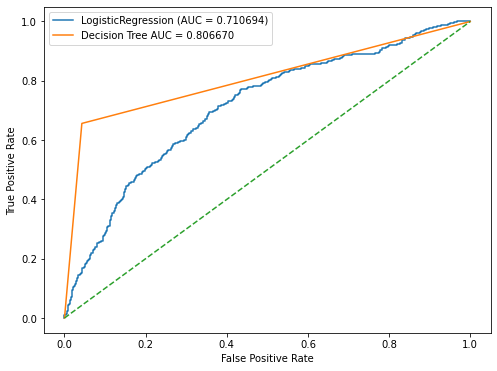

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'LogisticRegression (AUC = {lr_auc:2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree AUC = {dt_auc:2f}')
plt.plot([0,1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

***ROC Curve Visualization***

To visualize classifier performance across thresholds, I considered the ROC curve.  This plots TPR against FPR for all decision thresholds.  The area under the ROC curve (AUC) quantifies overall ranking quality: it equals the probability a random positive is scored above a random negative.  In our results, all models had AUC ≈0.80, indicating they rank churners reasonably well.  (A perfect classifier has AUC=1.0, while random guessing is 0.5.)  The above example ROC illustrates this tradeoff: a curve closer to the top-left indicates higher true positives at lower false positives.

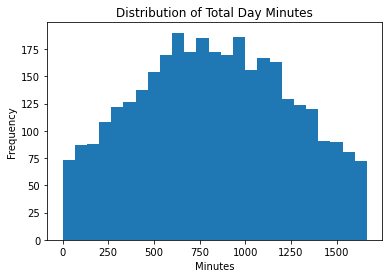

In [15]:
#Distribution of total day minutes
plt.Figure(figsize=(8,6))
plt.hist(data['total day minutes'], bins=25)
plt.title("Distribution of Total Day Minutes")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

<Figure size 1440x1152 with 0 Axes>

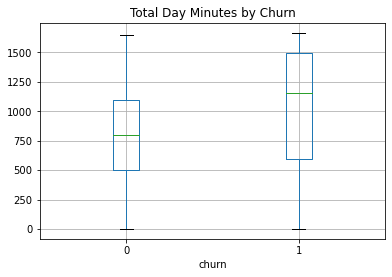

In [16]:
plt.figure(figsize=(20,16))
data.boxplot(column='total day minutes', by='churn')
plt.title("Total Day Minutes by Churn")
plt.suptitle("")
plt.show()

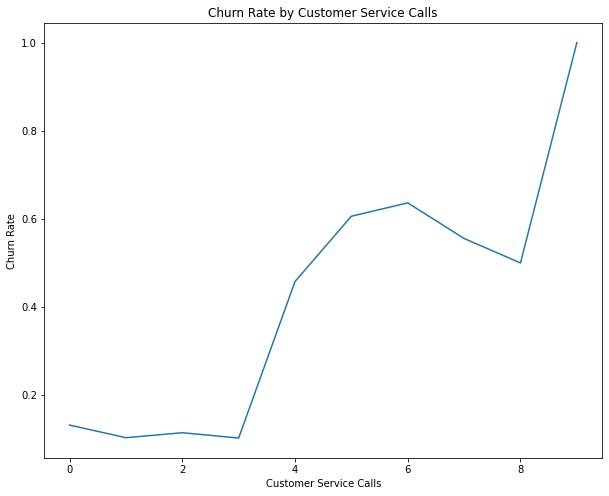

In [17]:
grouped = data.groupby('customer service calls')['churn'].mean()

plt.figure(figsize=(10,8))
plt.plot(grouped.index, grouped.values)
plt.xlabel("Customer Service Calls")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Customer Service Calls")
plt.show()

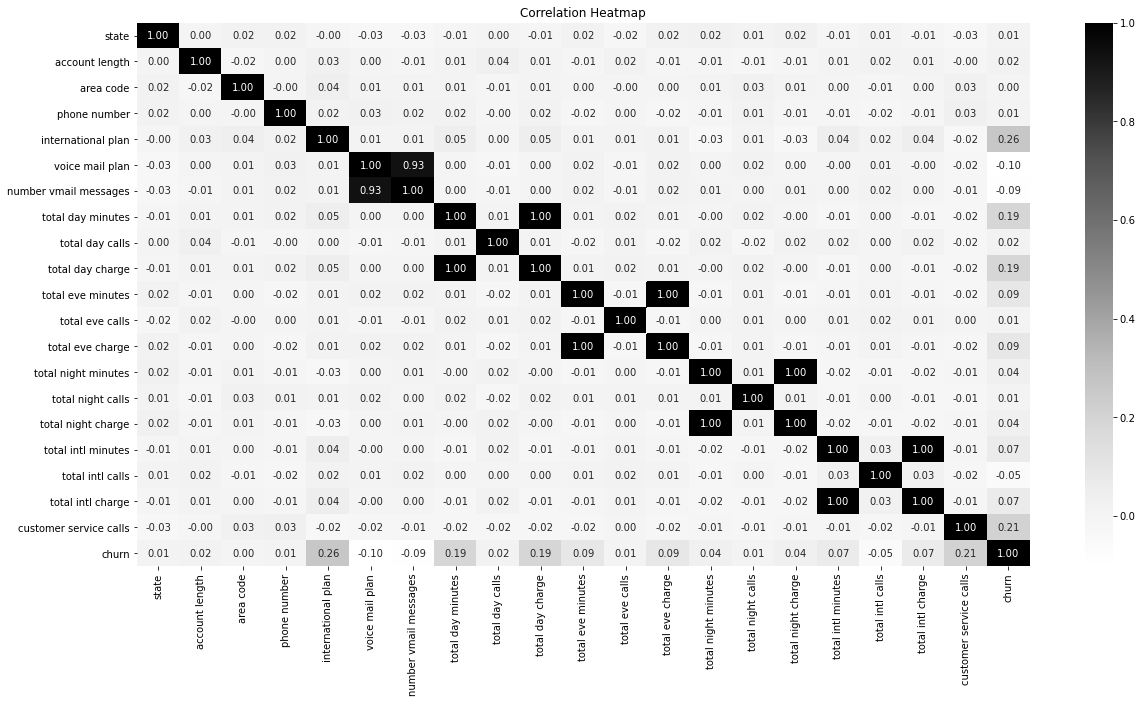

In [18]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, cmap='Greys', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages
avg_day_calls = data['total day calls'].mean()
avg_eve_calls = data['total eve calls'].mean()

avg_day_minutes = data['total day minutes'].mean()
avg_eve_minutes = data['total eve minutes'].mean()

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Average minutes
avg_minutes = [
    data['total day minutes'].mean(),
    data['total eve minutes'].mean(),
    data['total night minutes'].mean(),
    data['total intl minutes'].mean()
]

# Average charges
avg_charges = [
    data['total day charge'].mean(),
    data['total eve charge'].mean(),
    data['total night charge'].mean(),
    data['total intl charge'].mean()
]

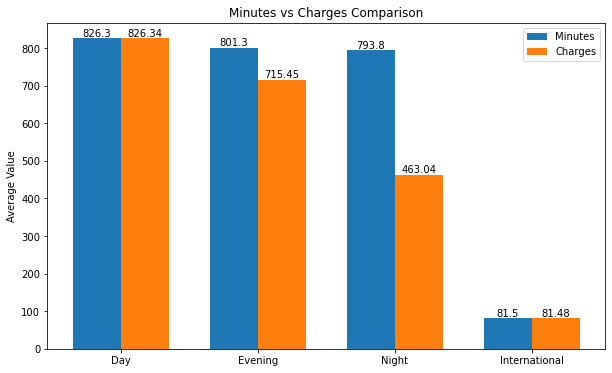

In [21]:
labels = ['Day', 'Evening', 'Night', 'International']

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, avg_minutes, width, label='Minutes')
bars2 = plt.bar(x + width/2, avg_charges, width, label='Charges')

plt.xticks(x, labels)
plt.title("Minutes vs Charges Comparison")
plt.ylabel("Average Value")
plt.legend()

# Add values on bars
for bar in bars1:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{bar.get_height():.1f}',
        ha='center',
        va='bottom'
    )

for bar in bars2:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom'
    )

plt.show()

In [22]:
#Decision Tress Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dt = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



#Accuracy: Overall correctness.

#Precision: Correct positive predictions.

#Recall: Ability to detect churners.

#F1-score: Balance between precision and recall.

Decision Tree Accuracy: 0.9224507283633248
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1985
           1       0.78      0.67      0.72       349

    accuracy                           0.92      2334
   macro avg       0.86      0.82      0.84      2334
weighted avg       0.92      0.92      0.92      2334



### Recommendations
Based on the model coefficients and evaluation:

Service Call Intervention: Customer service calls were a top predictor. SyriaTel should implement a "3-call threshold" where customers reaching this limit receive an automatic follow-up from a senior support specialist.

Daytime Usage Incentives: High daytime minutes are strongly linked to churn. Offering loyalty discounts or "Free Daytime Minutes" rewards for high-volume users could reduce price sensitivity.

Plan Reviews: The "International Plan" showed a high correlation with churn when usage was low. Suggesting a downgrade to a more appropriate plan for these users could build trust and prevent dissatisfaction.

### Next Steps
Advanced Modeling: Experiment with Random Forest or XGBoost to capture non-linear relationships that Logistic Regression might miss.

Geographic Analysis: Re-introduce "State" data to see if specific regional competitors are impacting SyriaTel in certain areas.